# A neural network approach to solve Schrodinger equation

## Motivation:
[Universal approximation theorem](http://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html) proved that **ANY** function can be approximated by a neural network with one hidden layer, using a bounded, countinuous, monotonically increasing activation function [[Hornik](http://zmjones.com/static/statistical-learning/hornik-nn-1991.pdf)].

If the Schrodinger equation solver is formulated as the approximator to estimate molecular orbital coefficients, for a given basis set and assuming that the activation function satisfies the necessary condition. The limit of exact approximator exist. It is therefore interesting how well this approximator can be modeled.

## A naive network structure:
### input layer $\rightarrow$ recurrent hidden layer $\rightarrow$ output layer

* Input layer: Given basis set $\{g_{\alpha}(\mathbf{r})\}_{\alpha}$, and number of electrons $N$, and structure file, containing nuclear positions $\{\mathbf{R}_I\}_I$ and the correspoinding nuclear charge $\{Z_I\}_I$. Compute the following:
 * Overlap matrix $[\mathbf{S}]_{\alpha\beta}=\int d\mathbf{r} g_\alpha(\mathbf{r})g_\beta(\mathbf{r})$
 * Canonical orthogonalization matrix $\mathbf{X} = \mathbf{U} / \sqrt{\mathbf{D}}$
 * Kinetic energy matrix $[\mathbf{K}]_{\alpha\beta} = -\frac{1}{2}\int d\mathbf{r}g_\alpha(\mathbf{r})\nabla^2 g_\beta(\mathbf{r})$
 * External potential matrix $[\mathbf{V}]_{\alpha\beta} = -\sum_I\int d\mathbf{r}\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})}{|\mathbf{r} - \mathbf{R}_I|}Z_I$
 * Electron repulsion matrix $[\mathbf{ER}]_{\alpha\beta\gamma\delta} = \int d\mathbf{r} d\mathbf{r}'\frac{g_\alpha(\mathbf{r})g_\beta(\mathbf{r})g_\gamma(\mathbf{r}')g_\delta(\mathbf{r}')}{|\mathbf{r}-\mathbf{r}'|}$
 * Initialize molecular orbital coefficients (MOV) $\mathbf{C_0}$ (zero matrix), weights $\mathbf{W}$ (random matrix), and bias $\mathbf{b}$ (zero vector).
* Hidden recurrent layer: Given a maximum iteration number $T$, update MOV by the recursive function
$$
\mathbf{C}_{t} = \mathbf{\sigma}(\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b}) = \mathbf{X}\cdot f_{\mathrm{eig}}\Big((\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b})^{\mathrm{T}}\cdot(\mathbf{C}_{t-1}\cdot\mathbf{W} + \mathbf{b})\Big),
$$
where $\mathbf{\sigma}([\cdot]) = \mathbf{X}\cdot f_{\mathrm{eig}}([\cdot]^{\mathrm{T}}[\cdot]): \mathbb{R}^{m\times m}\rightarrow\mathbb{R}^{m\times m}$ is the nonlinear activation function.
Such that $\mathbf{C}_t^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C}_t = \mathbf{1}\ \forall\ t$
(see section orthogonalization of the basis functions below).
* Output layer: Treat $\mathbf{C}_T$ as the converged Hartree-Fock molecular orbital coefficients and evaluate the Hartree-Fock energy normaly. That is (for conventional closed shell system)
$$
E = K + V + U + X + V_{nn},
$$
with density matrix $[\mathbf{P}]_{\alpha\beta}=2\sum_{i=1}^{N/2} C_{i\alpha}C_{i\beta}$ where 
 * Kinetic energy $K = tr(\mathbf{P}\cdot\mathbf{K})$
 * External pential energy $V = tr(\mathbf{P}\cdot\mathbf{V})$
 * and other terms $\cdots$

## Implementation

* Model construction:
All Gaussian basis matrix element can be evaluated by the ${\tt Horton}$ package. The computational graph (operational connectivity) can be constructed using ${\tt TensorFlow}$. 
* Trainning:
Standard backpropagation should work. There are two possible issues
 * Interface between ${\tt Horton}$ and ${\tt TensorFlow}$
 * Matrix operation derivatives, namely the derivative of trace and eigenvector decomposition in , e.g. $\frac{\partial K}{\partial\mathbf{W}} = \frac{\partial}{\partial\mathbf{W}} tr(\mathbf{P}\cdot\mathbf{K})$
 (see [/root_to_tensorflow/python/ops/linalg_grad.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/linalg_grad.py) and the corresponding [documentation](http://eprints.maths.ox.ac.uk/1079/1/NA-08-01.pdf) for details)

## Orthogonalization of the basis functions

Any random combination of Gaussian basis functions can be orthonormalized. An example of H$_2$ molecule using 3-21G basis function is shown

In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


Gaussian basis is normalized but not orthogonal to each other, as can be seen by the non-zero off-diagonal matrix element of the overlap matrix $\mathbf{S}$

In [2]:
mol = qtk.QMInp('xyz/h2.xyz', program='horton', basis_set='3-21g')
mol.olp

 _ __ _
/ (..) \ Welcome to HORTON 2.1.0!
\/ || \/
 |_''_|  HORTON is written and maintained by by Toon Verstraelen (1).

         This version contains contributions from Toon Verstraelen (1), Pawel Tecmer (2),
         Farnaz Heidar-Zadeh (2), Cristina E. González-Espinoza (2), Matthew Chan (2),
         Taewon D. Kim (2), Katharina Boguslawski (2), Stijn Fias (3),
         Steven Vandenbrande (1), Diego Berrocal (2), and Paul W. Ayers (2)

         (1) Center for Molecular Modeling (CMM), Ghent University, Ghent, Belgium.
         (2) The Ayers Group, McMaster University, Hamilton, Ontario, Canada.
         (3) General Chemistry (ALGC), Free University of Brussels, Brussels, Belgium.

         More information about HORTON can be found on this website:
         http://theochem.github.com/horton/

         The purpose of this log file is to track the progress and quality of a
         computation. Useful numerical output may be written to a checkpoint
         file and is accessible 

array([[ 1.        ,  0.64589894,  0.40432958,  0.48051762],
       [ 0.64589894,  1.        ,  0.48051762,  0.8360078 ],
       [ 0.40432958,  0.48051762,  1.        ,  0.64589894],
       [ 0.48051762,  0.8360078 ,  0.64589894,  1.        ]])

However, the molecular orbitals (MO) form a orthonormal basis set,
$$
\langle\psi_i|\psi_j\rangle = \delta_{ij},
$$
where 
$$
\psi_i(\mathbf{r}) = \sum_{\alpha=1}^M c_{i\alpha}g_\alpha(\mathbf{r}),\mbox{ and MO coefficients } [\mathbf{C}]_{i\alpha} = c_{i\alpha}.
$$
That is
$$
\mathbf{C}^{\mathrm{T}}\cdot\mathbf{S}\cdot\mathbf{C} = \mathbf{1}
$$

In [3]:
C = mol.mov
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,  -2.22044605e-16,  -1.11022302e-16,
          2.22044605e-16],
       [ -2.77555756e-17,   1.00000000e+00,   1.11022302e-16,
         -3.33066907e-16],
       [ -1.66533454e-16,  -2.22044605e-16,   1.00000000e+00,
          2.22044605e-16],
       [ -3.46944695e-18,  -9.02056208e-16,   9.71445147e-17,
          1.00000000e+00]])

An orthornormalization matrix $\mathbf{X}$ can be constructed by the overlap matrix $\mathbf{S}$ (canonical orthogonization). 
$$
\mathbf{X} = \mathbf{U}\frac{1}{\sqrt{\mathbf{D}}},
$$
where $\mathbf{D}$ and $\mathbf{U}$ are the eigenvalues and eigenvectors of the overlap matrix $\mathbf{S}$.

Any random combination of basis function can be orothornormalized by orthornormalization matrix.

In [4]:
# canonical orthogonalization transformation matirx
D, U = np.linalg.eig(mol.olp)
X = U / np.sqrt(D)

# random MO coefficients
B = np.random.random(U.shape)
# orthonormalized MO coefficients
C = X.dot(np.linalg.eig(B.T.dot(B))[1])

# orthonormalized random MO coefficients
C.T.dot(mol.olp).dot(C)

array([[  1.00000000e+00,   1.11022302e-16,   1.11022302e-16,
         -7.77156117e-16],
       [  3.88578059e-16,   1.00000000e+00,   5.68989300e-16,
         -3.60822483e-16],
       [ -1.11022302e-16,   3.88578059e-16,   1.00000000e+00,
          0.00000000e+00],
       [ -2.97071395e-16,  -5.92191227e-16,   2.45029691e-17,
          1.00000000e+00]])

## Construct H$_2$ dataset with varying bond length

In [5]:
inps = []
for R in np.arange(0.3, 3.1, 0.05):
    mol = qtk.Molecule()
    mol.build([[1, 0, 0, 0], [1, R, 0, 0]])
    inp = qtk.QMInp(mol, program='horton', basis_set='3-21g')
    inp.run()
    D, U = np.linalg.eig(inp.olp)
    inp.X = U / np.sqrt(D)
    inps.append(inp)

Initialized: <horton.gbasis.cext.GOBasis object at 0x2b15282eef58>
  Number of basis functions         : 4
  Number of normalization constants : 6
  Maximum shell type                : 0
  Center     0 :  S2 S1
  Center     1 :  S2 S1

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b1528d40490>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   4.93725e-01
   1   3.74508e-02
   2   6.08114e-03
   3   9.11264e-04
   4   1.34917e-04
   5   1.99395e-05
   6   2.94609e-06
   7   4.35272e-07

Contributions to the energy:
~~~~~~~~

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152ad94b50>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   4.66692e-01
   1   3.36204e-02
   2   4.87320e-03
   3   6.85536e-04
   4   9.61206e-05
   5   1.34713e-05
   6   1.88789e-06
   7   2.64570e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152ade4590>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   4.33806e-01
   1   2.49187e-02
   2   3.59495e-03
   3   5.23592e-04
   4   7.64198e-05
   5   1.11573e-05
   6   1.62905e-06
   7   2.37854e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152ae3fd50>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   4.02152e-01
   1   1.64959e-02
   2   2.44412e-03
   3   3.71920e-04
   4   5.68392e-05
   5   8.69231e-06
   6   1.32943e-06
   7   2.03331e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152ae87c10>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   3.76543e-01
   1   1.10748e-02
   2   1.66795e-03
   3   2.59502e-04
   4   4.05768e-05
   5   6.34971e-06
   6   9.93765e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                        

Initialized: <horton.gbasis.cext.GOBasis object at 0x2b15282c2f58>
  Number of basis functions         : 4
  Number of normalization constants : 6
  Maximum shell type                : 0
  Center     0 :  S2 S1
  Center     1 :  S2 S1

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152aedb2d0>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   3.56427e-01
   1   8.26938e-03
   2   1.25287e-03
   3   1.96463e-04
   4   3.09682e-05
   5   4.88546e-06
   6   7.70817e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                               kin        0.738253161085
                                           hartree        0.909816056107
                                              x_hf       -0.454908028053
                                                ne       -2.442744593094
                                                nn        0.302386999361
                                             total       -0.947196404595
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Initialized: <horton.gbasis.cext.GOBasis object at 0x2b15282c29a8>
  Number of basis functions         : 4
  Number of normalization constants : 6
  Maximum shell type                : 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152af9cc10>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   3.28397e-01
   1   6.50073e-03
   2   9.58054e-04
   3   1.46850e-04
   4   2.26376e-05
   5   3.49274e-06
   6   5.38964e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                        

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152affb790>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   3.15972e-01
   1   6.30324e-03
   2   8.94524e-04
   3   1.32666e-04
   4   1.97976e-05
   5   2.95705e-06
   6   4.41739e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                              term                 Value
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Initialized: <horton.gbasis.cext.GOBasis object at 0x2b15282988d8>
  Number of basis functions         : 4
  Number of normalization constants : 6
  Maximum shell type                : 0
  Center     0 :  S2 S1
  Center     1 :  S2 S1

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152b051f10>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   3.05436e-01
   1   6.30722e-03
   2   8.53401e-04
   3   1.21313e-04
   4   1.735

Initialized: <horton.gbasis.cext.GOBasis object at 0x2b1528298c80>
  Number of basis functions         : 4
  Number of normalization constants : 6
  Maximum shell type                : 0
  Center     0 :  S2 S1
  Center     1 :  S2 S1

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152b0b4cd0>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   2.96572e-01
   1   6.37515e-03
   2   8.19625e-04
   3   1.11240e-04
   4   1.52033e-05
   5   2.07983e-06
   6   2.84558e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~

  Number of normalization constants : 6
  Maximum shell type                : 0
  Center     0 :  S2 S1
  Center     1 :  S2 S1

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x2b152b110490>
  Size               : 1856
  Switching function : k=3

Performing a core Hamiltonian guess.

Starting plain SCF solver. ndm=1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0   2.89115e-01
   1   6.43886e-03
   2   7.87940e-04
   3   1.02175e-04
   4   1.33445e-05
   5   1.74447e-06
   6   2.28076e-07

Contributions to the energy:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                 

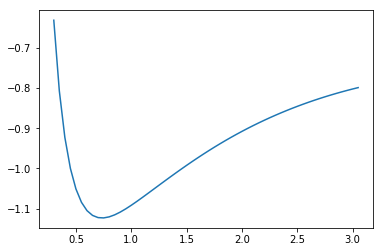

In [6]:
E = [inp.ht_ham.cache['energy'] for inp in inps]
R = [inp.molecule.R[1,0] for inp in inps]
plt.plot(R, E)

## Construct Tensorflow model 

In [7]:
import tensorflow as tf

In [69]:
def naive_qnet(mol, sess):
    """
    Take qctoolkit horton input object as input, where all matrices are already calculated.
    Maybe it would be necessary to extract numpy matrix value and pass it as tf tensor.
    """
    
    # seems fine to pass molecule object and extract
    # Hamiltonian matrix components for energy evaluation
    S = tf.constant(mol.olp, shape=mol.olp.shape, name='overlap')
    K = tf.constant(mol.kin, shape=mol.kin.shape, name='kinetic')
    X = tf.constant(mol.X, shape=mol.X.shape, name='X')
    Er = tf.constant(mol.er, shape=mol.er.shape, name='electron_repulsion')
    
    C = tf.Variable(tf.zeros_like(S, dtype=tf.float64), name='MO_coeffs')
    W = tf.Variable(tf.truncated_normal(S.shape, dtype=tf.float64), name='weights')
    b = tf.Variable(tf.zeros(S.shape[0], dtype=tf.float64), name='biases')
    
    # it seems the initialization need to be done inside the function?
    sess.run(tf.global_variables_initializer())
    
    def update_C(C, W, b):
        C_new = tf.add(tf.matmul(C, W), b)
        C2_symm = tf.matmul(tf.transpose(C_new), C_new)
        _, C = tf.self_adjoint_eig(C2_symm)
        return C
    
    C = update_C(C, W, b)
    C = update_C(C, W, b)
    C = update_C(C, W, b)
    C = update_C(C, W, b)
       
    return C

In [70]:
with tf.Session() as sess:
    print sess.run(naive_qnet(inps[0], sess))

[[-0.24842149 -0.04331856  0.51403976 -0.81986182]
 [-0.1073626  -0.24870244 -0.83546076 -0.47814818]
 [ 0.8585275   0.40270527 -0.05088698 -0.31332014]
 [-0.43553481  0.879829   -0.18756056 -0.03211554]]


In [61]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run(naive_qnet(), feed_dict = {mol:inps[0]})

TypeError: naive_qnet() takes exactly 1 argument (0 given)

In [36]:
inps[0].olp.dot(inps[1].kin)

array([[ 2.71048534,  0.85210735,  2.62094753,  0.84697998],
       [ 2.13381877,  0.87495852,  2.11458792,  0.87349294],
       [ 2.62094753,  0.84697998,  2.71048534,  0.85210735],
       [ 2.11458792,  0.87349294,  2.13381877,  0.87495852]])

In [13]:
np.linalg.eig(inps[0].olp)[1][:,::1]

array([[-0.48806496, -0.51165671,  0.68722899,  0.16648217],
       [-0.51165671,  0.48806496,  0.16648217, -0.68722899],
       [-0.48806496, -0.51165671, -0.68722899, -0.16648217],
       [-0.51165671,  0.48806496, -0.16648217,  0.68722899]])